# Hierarchical forecasting

In forecasting, we often find ourselves in need of forecasts for both lower- and higher (temporal) granularities, such as product demand forecasts but also product category or product department forecasts. These granularities can be formalized through the use of a hierarchy. In hierarchical forecasting, we create forecasts that are coherent with respect to a pre-specified hierarchy of the underlying time series.

With TimeGPT, we can create forecasts for multiple time series. We can subsequently post-process these forecasts using hierarchical forecasting techniques of [HierarchicalForecast](https://nixtlaverse.nixtla.io/hierarchicalforecast/index.html).

In [ ]:
#| hide
import sys

In [ ]:
#| hide
IN_COLAB = 'google.colab' in sys.modules

In [ ]:
#| hide
if IN_COLAB:
    %pip install nixtla hierarchicalforecast

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge

In [ ]:
#| echo: false
if not IN_COLAB:
    colab_badge('docs/tutorials/14_hierarchical_forecasting')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/14_hierarchical_forecasting.ipynb)

## 1. Import packages
First, we import the required packages and initialize the Nixtla client.

In [ ]:
#| hide
if not IN_COLAB:
    from itertools import product

    from fastcore.test import test_eq, test_fail, test_warns
    from dotenv import load_dotenv

In [ ]:
#| hide
if not IN_COLAB:
    load_dotenv()

False

In [ ]:
import pandas as pd
import numpy as np

from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 2. Load data

We use the Australian Tourism dataset, from [Forecasting, Principles and Practices](https://otexts.com/fpp3/) which contains data on Australian Tourism. We are interested in forecasts for Australia's 7 States, 27 Zones and 76 Regions. This constitutes a hierarchy, where forecasts for the lower levels (e.g. the regions Sidney, Blue Mountains and Hunter) should be coherent with the forecasts of the higher levels (e.g. New South Wales).

<img src="https://github.com/Nixtla/nixtla/blob/main/nbs/img/australia_tourism.png?raw=true" alt="Figure 1. Overview of Australia" width="700" />
<img src="https://github.com/Nixtla/nixtla/blob/main/nbs/img/australia_hierarchy.png?raw=true" alt="Figure 2. Overview of hierarchy of Australia" width="700" />

The dataset only contains the time series at the lowest level, so we need to create the time series for all hierarchies.

In [ ]:
Y_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')
Y_df = Y_df.rename({'Trips': 'y', 'Quarter': 'ds'}, axis=1)
Y_df.insert(0, 'Country', 'Australia')
Y_df = Y_df[['Country', 'Region', 'State', 'Purpose', 'ds', 'y']]
Y_df['ds'] = Y_df['ds'].str.replace(r'(\d+) (Q\d)', r'\1-\2', regex=True)
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

Y_df.head(10)

C:\Users\ospra\AppData\Local\Temp\ipykernel_28980\3753786659.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Y_df['ds'] = pd.to_datetime(Y_df['ds'])


,Country,Region,State,Purpose,ds,y
0,Australia,Adelaide,South Australia,Business,1998-01-01,135.077690
1,Australia,Adelaide,South Australia,Business,1998-04-01,109.987316
2,Australia,Adelaide,South Australia,Business,1998-07-01,166.034687
3,Australia,Adelaide,South Australia,Business,1998-10-01,127.160464
4,Australia,Adelaide,South Australia,Business,1999-01-01,137.448533
5,Australia,Adelaide,South Australia,Business,1999-04-01,199.912586
6,Australia,Adelaide,South Australia,Business,1999-07-01,169.355090
7,Australia,Adelaide,South Australia,Business,1999-10-01,134.357937
8,Australia,Adelaide,South Australia,Business,2000-01-01,154.034398
9,Australia,Adelaide,South Australia,Business,2000-04-01,168.776364


The dataset can be grouped in the following hierarchical structure.

In [ ]:
spec = [
    ['Country'],
    ['Country', 'State'], 
    ['Country', 'Purpose'], 
    ['Country', 'State', 'Region'], 
    ['Country', 'State', 'Purpose'], 
    ['Country', 'State', 'Region', 'Purpose']
]

Using the `aggregate` function from `HierarchicalForecast` we can get the full set of time series.

::: {.callout-note}
You can install `hierarchicalforecast` with `pip`:
    
```shell
pip install hierarchicalforecast
```
:::

In [ ]:
from hierarchicalforecast.utils import aggregate

In [ ]:
Y_df, S_df, tags = aggregate(Y_df, spec)
Y_df = Y_df.reset_index()

Y_df.head(10)

,unique_id,ds,y
0,Australia,1998-01-01,23182.197269
1,Australia,1998-04-01,20323.380067
2,Australia,1998-07-01,19826.640511
3,Australia,1998-10-01,20830.129891
4,Australia,1999-01-01,22087.353380
5,Australia,1999-04-01,21458.373285
6,Australia,1999-07-01,19914.192508
7,Australia,1999-10-01,20027.925640
8,Australia,2000-01-01,22339.294779
9,Australia,2000-04-01,19941.063482


We use the final two years (8 quarters) as test set.

In [ ]:
Y_test_df = Y_df.groupby('unique_id').tail(8)
Y_train_df = Y_df.drop(Y_test_df.index)

## 3. Hierarchical forecasting with TimeGPT

First, we create base forecasts for all the time series with TimeGPT. Note that we set `add_history=True`, as we will need the in-sample fitted values of TimeGPT. 

We will predict 2 years (8 quarters), starting from 01-01-2016.

In [ ]:
timegpt_fcst = nixtla_client.forecast(df=Y_train_df, h=8, freq='QS', add_history=True)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...


In [ ]:
timegpt_fcst_insample = timegpt_fcst.query("ds < '2016-01-01'")
timegpt_fcst_outsample = timegpt_fcst.query("ds >= '2016-01-01'")

Let's plot some of the forecasts, starting from the highest aggregation level (`Australia`), to the lowest level (`Australia/Queensland/Brisbane/Holiday`). We can see that there is room for improvement in the forecasts.

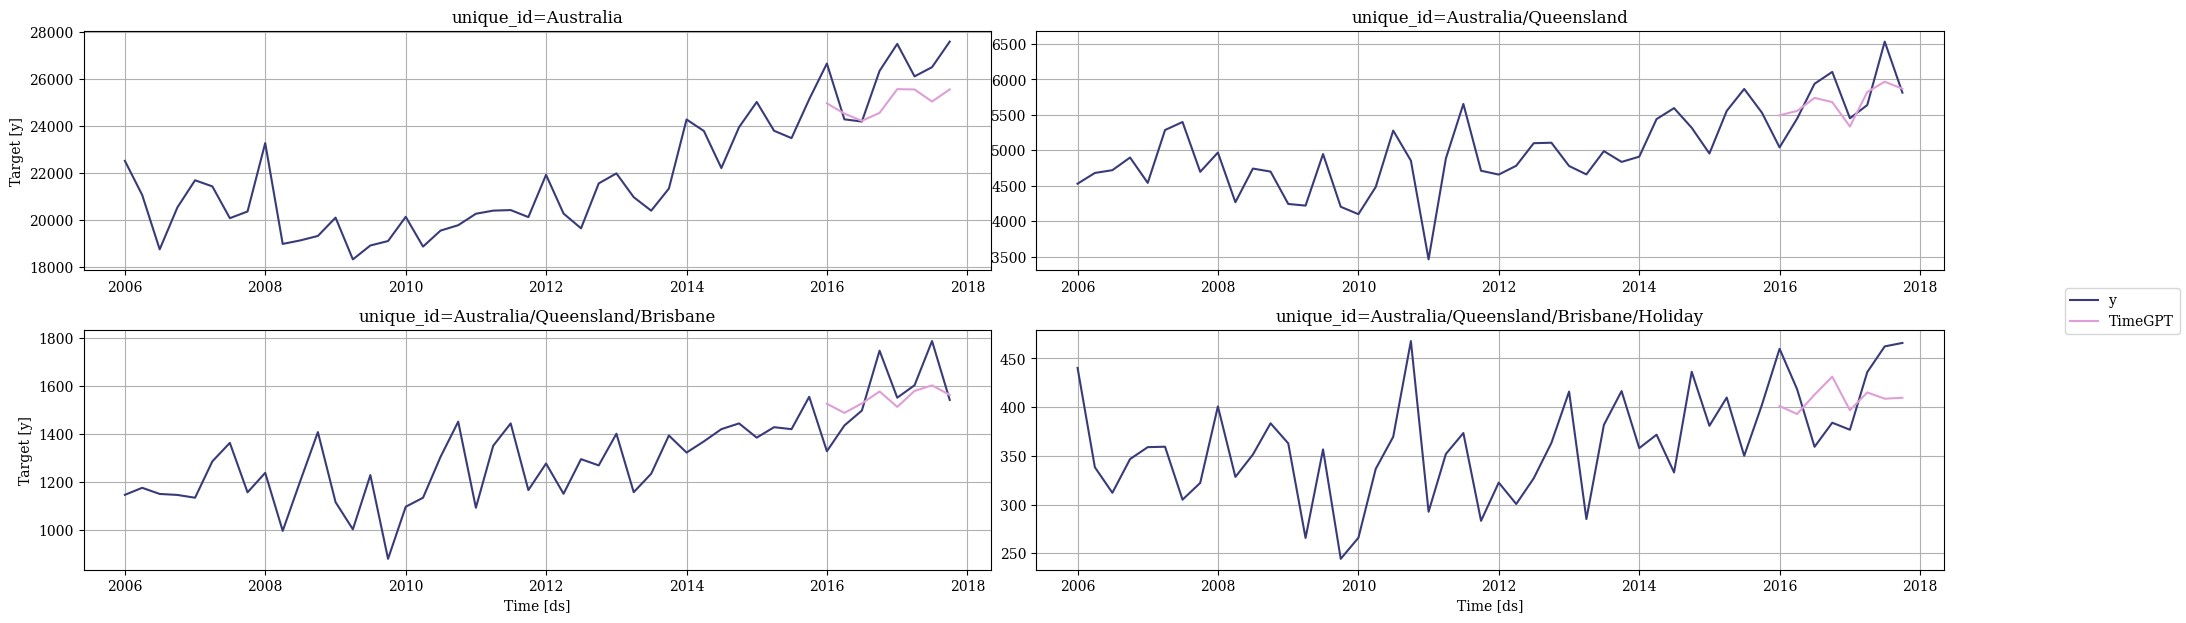

In [ ]:
nixtla_client.plot(
    Y_df, 
    timegpt_fcst_outsample, 
    max_insample_length=4 * 12, 
    unique_ids=['Australia', 'Australia/Queensland','Australia/Queensland/Brisbane', 'Australia/Queensland/Brisbane/Holiday']
)

We can make these forecasts coherent to the specified hierarchy by using a `HierarchicalReconciliation` method from `NeuralForecast`. We will be using the [MinTrace](https://nixtlaverse.nixtla.io/hierarchicalforecast/methods.html) method.

In [ ]:
from hierarchicalforecast.methods import MinTrace
from hierarchicalforecast.core import HierarchicalReconciliation

In [ ]:
reconcilers = [
    MinTrace(method='ols'),
    MinTrace(method='mint_shrink'),
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)

Y_df_with_insample_fcsts = Y_df.copy()
Y_df_with_insample_fcsts['ds'] = Y_df_with_insample_fcsts['ds'].astype(str)
Y_df_with_insample_fcsts = timegpt_fcst_insample.merge(Y_df_with_insample_fcsts)
Y_df_with_insample_fcsts = Y_df_with_insample_fcsts.set_index('unique_id')

Y_rec_df = hrec.reconcile(Y_hat_df=timegpt_fcst_outsample.set_index('unique_id'), Y_df=Y_df_with_insample_fcsts, S=S_df, tags=tags)

Again, we plot some of the forecasts. We can see a few, mostly minor differences in the forecasts.

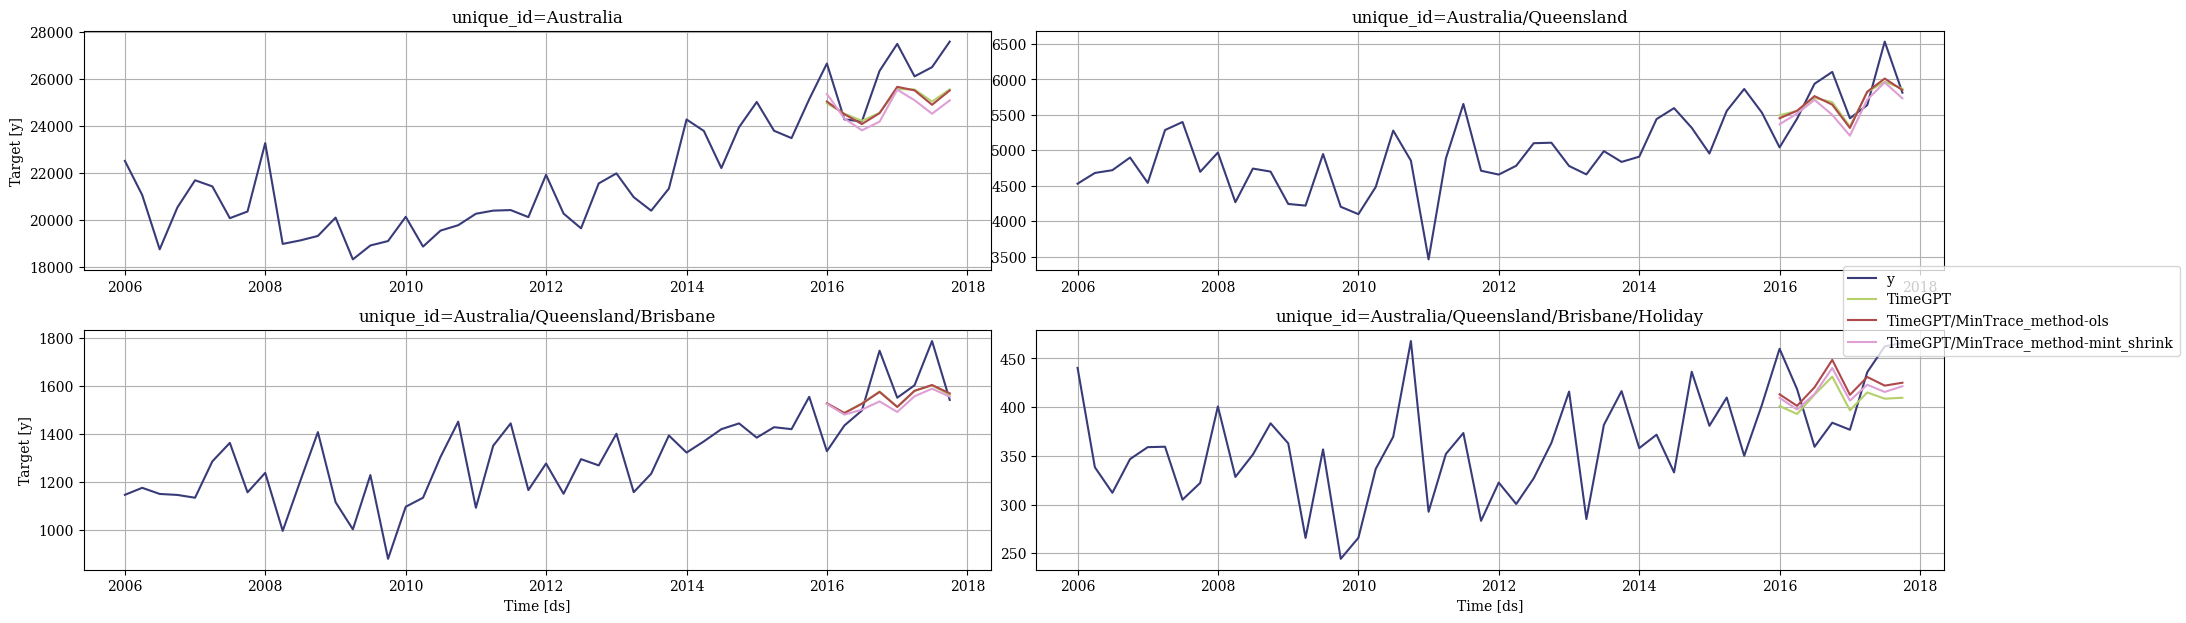

In [ ]:
nixtla_client.plot(
    Y_df, 
    Y_rec_df.reset_index(), 
    max_insample_length=4 * 12, 
    unique_ids=['Australia', 'Australia/Queensland','Australia/Queensland/Brisbane', 'Australia/Queensland/Brisbane/Holiday']
)

Let's numerically verify the forecasts to the situation where we don't apply a post-processing step. We can use `HierarchicalEvaluation` for this.

In [ ]:
from hierarchicalforecast.evaluation import HierarchicalEvaluation

In [ ]:
def rmse(y, y_hat):
    return np.mean(np.sqrt(np.mean((y-y_hat)**2, axis=1)))

eval_tags = {}
eval_tags['Total'] = tags['Country']
eval_tags['Purpose'] = tags['Country/Purpose']
eval_tags['State'] = tags['Country/State']
eval_tags['Regions'] = tags['Country/State/Region']
eval_tags['Bottom'] = tags['Country/State/Region/Purpose']
eval_tags['All'] = np.concatenate(list(tags.values()))

evaluator = HierarchicalEvaluation(evaluators=[rmse])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_df.rename(columns={'y': 'TimeGPT'}), Y_test_df=Y_test_df.set_index('unique_id'),
        tags=eval_tags, Y_df=Y_train_df.set_index('unique_id')
)
evaluation = evaluation.drop(labels='Overall', level='level')
evaluation.columns = ['Base', 'MinTrace(ols)', 'MinTrace(mint_shrink)']
evaluation = evaluation.map('{:.2f}'.format)

In [ ]:
evaluation

,,Base,MinTrace(ols),MinTrace(mint_shrink)
level,metric,,,
Total,rmse,1433.14,1436.12,1639.77
Purpose,rmse,482.10,475.65,511.14
State,rmse,275.86,278.39,295.03
Regions,rmse,49.40,47.91,48.10
Bottom,rmse,19.32,19.11,18.87
All,rmse,43.00,42.50,43.54


We made a small improvement in overall RMSE by reconciling the forecasts with `MinTrace(ols)`, and made them slightly worse using `MinTrace(mint_shrink)`, indicating that the base forecasts were relatively strong already. 

However, we now have coherent forecasts too - so not only did we make a (small) accuracy improvement, we also got coherency to the hierarchy as a result of our reconciliation step.

**References**

* [Hyndman, Rob J., and George Athanasopoulos (2021). "Forecasting: Principles and Practice (3rd Ed)"](https://otexts.com/fpp3/)